<h1>News Topic Classification</h1>
<p>In this project, we developed a Deep Learning model to automatically classify news articles into predefined categories such as sports, politics, business, and entertainment. We preprocessed the text data by tokenizing, removing stopwords, and encoding it using word embeddings. Our model, trained on a labeled dataset of news articles, achieved high accuracy in categorizing articles, providing a valuable tool for organizing and analyzing large volumes of news content."

In [38]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer

def returnLabel(category):
    if category == 1:
        return "World"
    elif category == 2:
        return "Sports"
    elif category == 3:
        return "Business"
    else:
        return "Science/Technology"

<h2>Data Preprocessing</h2>
<p>Loading the dataset and performing preprocessing steps which include lower casing, tokenization, stopwords and punctuation removal, and stemming.</p>

In [39]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Load the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

df = pd.concat([train, test], ignore_index=True)

# Preprocessing
stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return " ".join(stemmed_tokens)

# Concatenate 'title' and 'description' columns
df['clean_text'] = (df['Title'] + " " + df['Description']).apply(preprocess_text)

# Encode the labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Class Index'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sahil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sahil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<h1>Data Visualization</h1>
<p>Visualizing the Class Distribution, Article length distribution and the top 10 most common words in each class.</p>

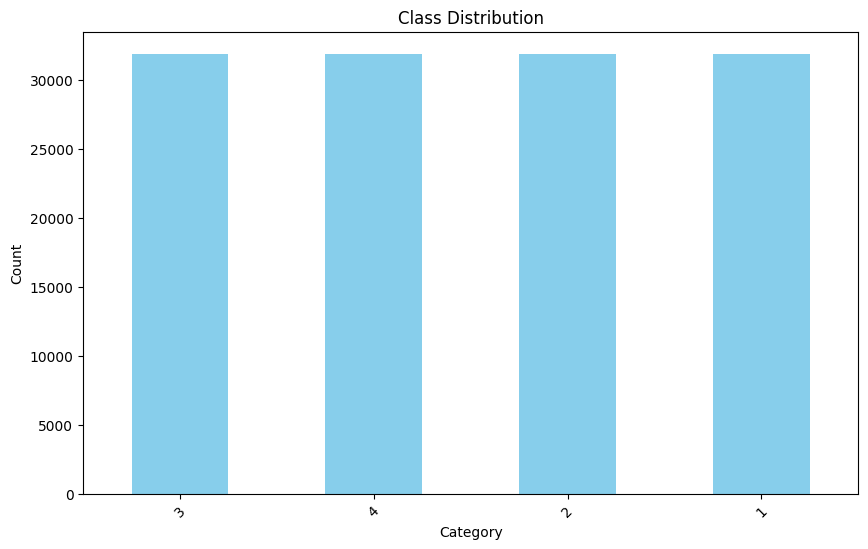

In [40]:
# Class Distribution
plt.figure(figsize=(10, 6))
df['Class Index'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

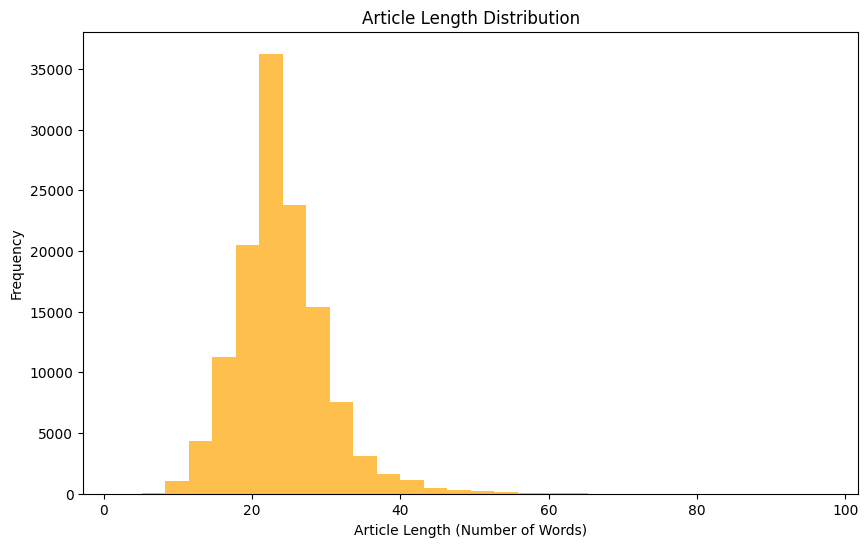

In [41]:
# Article Length Distribution
df['article_length'] = df['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(df['article_length'], bins=30, color='orange', alpha=0.7)
plt.title('Article Length Distribution')
plt.xlabel('Article Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

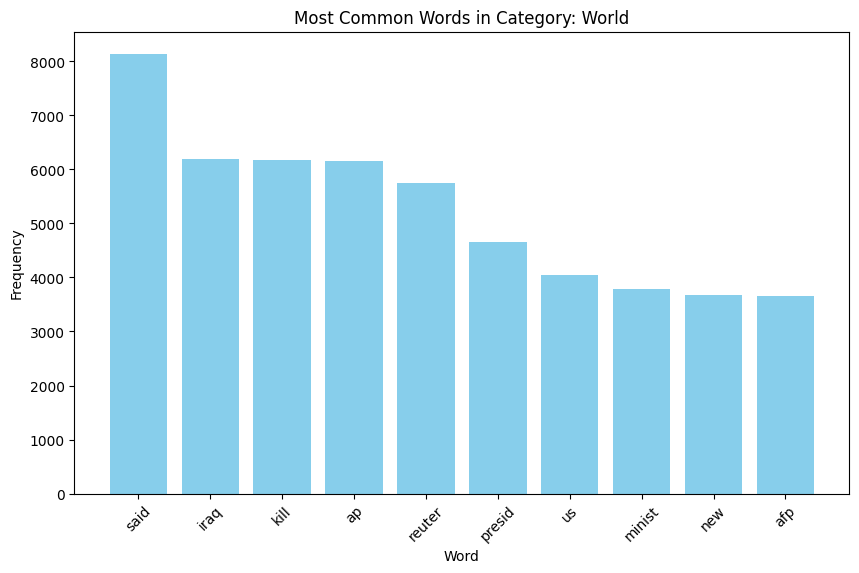

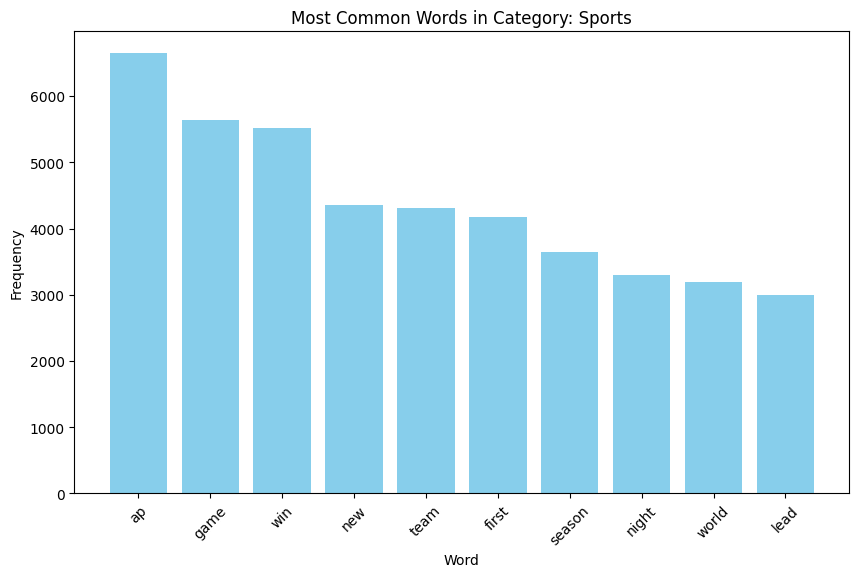

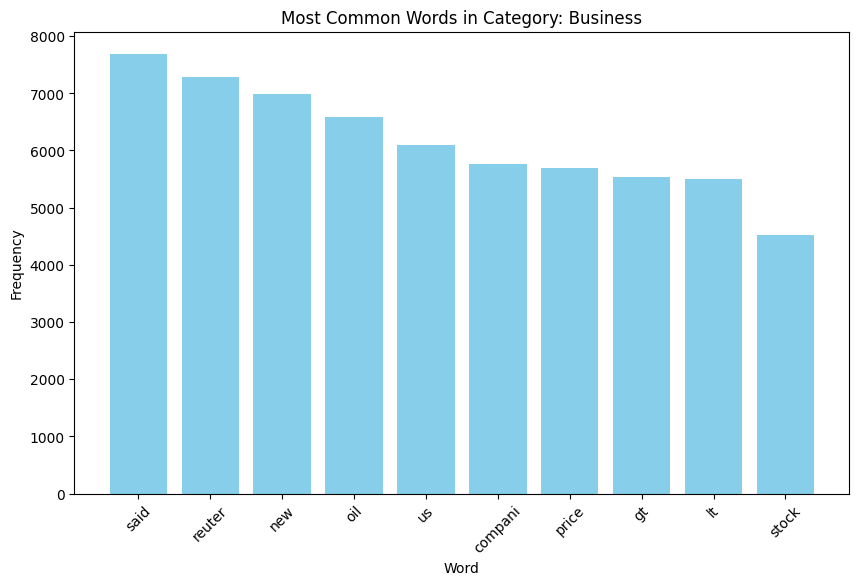

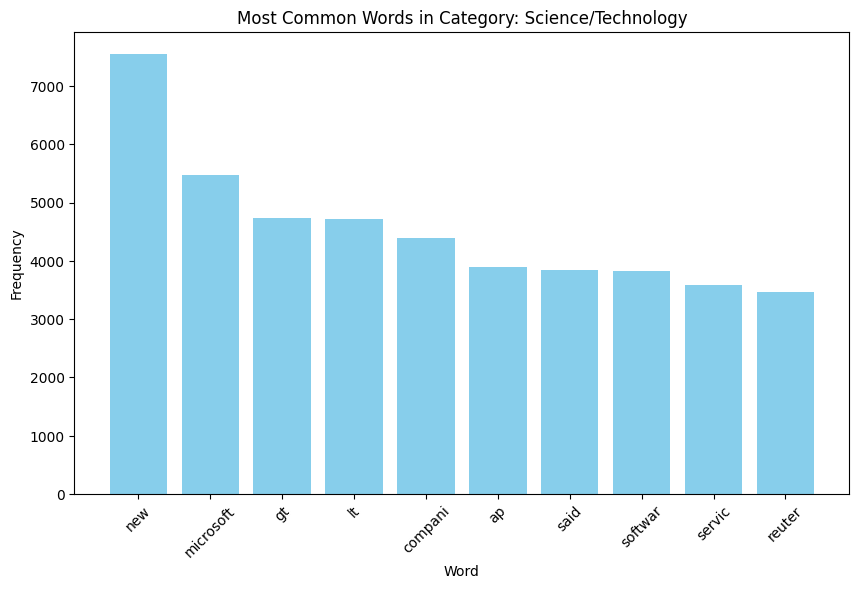

In [42]:
from collections import Counter

# Function to get the most common words for a given category
def get_top_words(category, n=10):
    category_text = ' '.join(df[df['Class Index'] == category]['clean_text'].tolist())
    words = category_text.split()
    word_counts = Counter(words)
    top_words = word_counts.most_common(n)
    return top_words

# Plot the most common words for each category
categories = [1, 2, 3, 4]
num_top_words = 10  # Number of top words to display
for category in categories:
    top_words = get_top_words(category, num_top_words)
    words, counts = zip(*top_words)
    
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue')
    plt.title(f'Most Common Words in Category: {returnLabel(category)}')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()


<h1>Model Training and Evaluation</h1>
<p>The deep learning model is defined, trained, and evaluated in this section.</p>
<p>Model Architecture:</p>
<img src="Model_architecture.png">

In [43]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_length = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')



In [44]:
# Model Definition
embedding_dim = 128
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])


In [45]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compiling the Model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Training the Model
history = model.fit(X_train_padded, y_train, epochs=25, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/25
1436/1436 [==============================] - 18s 9ms/step - loss: 0.4711 - accuracy: 0.8226 - val_loss: 0.2904 - val_accuracy: 0.9087
Epoch 2/25
1436/1436 [==============================] - 12s 8ms/step - loss: 0.2586 - accuracy: 0.9209 - val_loss: 0.2703 - val_accuracy: 0.9075
Epoch 3/25
1436/1436 [==============================] - 12s 9ms/step - loss: 0.2032 - accuracy: 0.9380 - val_loss: 0.2667 - val_accuracy: 0.9112
Epoch 4/25
1436/1436 [==============================] - 12s 8ms/step - loss: 0.1514 - accuracy: 0.9536 - val_loss: 0.3103 - val_accuracy: 0.9092
Epoch 5/25
1436/1436 [==============================] - 12s 9ms/step - loss: 0.1084 - accuracy: 0.9665 - val_loss: 0.3203 - val_accuracy: 0.9018
Epoch 6/25
1436/1436 [==============================] - 13s 9ms/step - loss: 0.0755 - accuracy: 0.9774 - val_loss: 0.4211 - val_accuracy: 0.9008


In [46]:
# Evaluating the model
test_loss, test_acc = model.evaluate(X_test_padded, y_test)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = np.argmax(model.predict(X_test_padded), axis=-1)

798/798 [==============================] - 2s 3ms/step - loss: 0.2830 - accuracy: 0.9076
Test accuracy: 0.9076410531997681
798/798 [==============================] - 2s 2ms/step


<h2>Saving the Model</h2>
<p>The best model from the training is saved in *.h5 format for future use.</p>

In [47]:
model.save("Best_Model.h5")

<h2>Model Testing</h2>
<p>In this section, the user can test the model by running it on a specific record from the testing dataset.</p>

In [63]:
c = int(input("Enter the record number to be tested: "))
print("Record Index: ", c)
print("Content: ", X_test.iloc[c])
print("Actual: ", returnLabel(y_test.iloc[c]))
print("Predicted: ", returnLabel(predictions[c]))

Record Index:  3
Content:  antibiot hope parkinson antibiot use treat leprosi tuberculosi show promis therapi parkinson diseas
Actual:  Science/Technology
Predicted:  Science/Technology
